In [ ]:

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 

from tensorflow.keras import Sequential, Input, layers, Model
from tensorflow.keras.layers import Dropout, MaxPool2D, Conv2D, BatchNormalization, MaxPooling2D, Dense, Flatten, InputLayer, Activation, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix, classification_report

import os
from distutils.dir_util import copy_tree, remove_tree

In [7]:
print(tf.__version__)

2.6.4


In [8]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    brightness_range=[0.8, 1.02],
                                    zoom_range=[.99, 1.01],
                                    horizontal_flip=True,
                                    fill_mode='constant')

In [9]:
base_dir = "../input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/"

# Define training directory 
training_data_dir = base_dir + "train/"
# Define testing directory
test_data_dir = base_dir + "test/"
# Create a project directory to combine both training and testing images in order to split them later.
project_dir = "./dataset/"

if os.path.exists(project_dir):
    remove_tree(project_dir)
os.mkdir(project_dir)
copy_tree(training_data_dir, project_dir)
copy_tree(test_data_dir, project_dir)

['./dataset/ModerateDemented/30.jpg',
 './dataset/ModerateDemented/29.jpg',
 './dataset/ModerateDemented/28.jpg',
 './dataset/ModerateDemented/32 (2).jpg',
 './dataset/ModerateDemented/27 (2).jpg',
 './dataset/ModerateDemented/31.jpg',
 './dataset/ModerateDemented/32.jpg',
 './dataset/ModerateDemented/30 (2).jpg',
 './dataset/ModerateDemented/29 (2).jpg',
 './dataset/ModerateDemented/27.jpg',
 './dataset/ModerateDemented/28 (2).jpg',
 './dataset/ModerateDemented/31 (2).jpg',
 './dataset/NonDemented/31 (51).jpg',
 './dataset/NonDemented/30 (84).jpg',
 './dataset/NonDemented/28 (25).jpg',
 './dataset/NonDemented/31 (100).jpg',
 './dataset/NonDemented/28 (28).jpg',
 './dataset/NonDemented/32 (63).jpg',
 './dataset/NonDemented/32 (65).jpg',
 './dataset/NonDemented/30 (31).jpg',
 './dataset/NonDemented/26 (92).jpg',
 './dataset/NonDemented/32 (32).jpg',
 './dataset/NonDemented/29 (32).jpg',
 './dataset/NonDemented/28 (98).jpg',
 './dataset/NonDemented/28 (92).jpg',
 './dataset/NonDemented/2

In [10]:
# Define the class names (that will be useful in order to match prediction while testing, to class labels later).

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

# Define the image size (the images in this dataset are 176x208)

IMAGE_SIZE = [176, 176]

# Define a dimension tuple equal to the image size which will be used to load the picture using data generators
DIM = (176, 176)

In [11]:
all_data_gen = train_datagen.flow_from_directory(directory=project_dir, 
                                             target_size=DIM, 
                                             batch_size=6500,
                                             shuffle=False)

Found 6400 images belonging to 4 classes.


**All images are loading succesfully and belong to 4 different classes. It is important to match the class indices for each class in order to understand the model's predictions later.**

In [7]:
all_data_gen.class_indices

{'MildDemented': 0,
 'ModerateDemented': 1,
 'NonDemented': 2,
 'VeryMildDemented': 3}

In [12]:
training_data, training_labels = all_data_gen.next()

In [13]:
print("Training Data shape: " , training_data.shape)
print("Training Labels shape: " , training_labels.shape)

Training Data shape:  (6400, 176, 176, 3)
Training Labels shape:  (6400, 4)


In [14]:
import gc
gc.collect()

46

In [15]:
sm_resample = SMOTE(random_state=48)
training_data, training_labels = sm_resample.fit_resample(training_data.reshape(-1, 176 * 176 * 3), training_labels)
training_data = training_data.reshape(-1, 176, 176, 3)

print(training_data.shape, training_labels.shape)

(12800, 176, 176, 3) (12800, 4)


**Split Data into training, validation and test data.**

In [16]:
training_data, valid_data, training_labels, valid_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state=48)
training_data, test_data, training_labels, test_labels = train_test_split(training_data, training_labels, test_size = 0.2, random_state=48)

In [17]:
print("Training Data shape: " , training_data.shape)
print("Training Labels shape: " , training_labels.shape)
print("Validation Data shape: " , valid_data.shape)
print("Validation Labels shape: " , valid_labels.shape)
print("Testing Data shape: " , test_data.shape)
print("Testing Labels shape: " , test_labels.shape)

Training Data shape:  (8192, 176, 176, 3)
Training Labels shape:  (8192, 4)
Validation Data shape:  (2560, 176, 176, 3)
Validation Labels shape:  (2560, 4)
Testing Data shape:  (2048, 176, 176, 3)
Testing Labels shape:  (2048, 4)


**In total 8192 training images will be fitted to the CNN model below.**

**Define a CNN model with 5 single convolutional layers and 5 dense layers.**

In [18]:
gc.collect()

92

In [19]:
model = Sequential([
        Input(shape=(176, 176, 3)),
        Conv2D(16, 3, activation="relu", padding='same'),
        MaxPool2D(),
        Conv2D(32, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(64, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Conv2D(128, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.2),
        Conv2D(256, 3, activation="relu", padding='same'),
        BatchNormalization(),
        MaxPool2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation="relu"),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(4, activation='softmax')        
    ],  name = "cnn_model_singleLayers")

2022-08-18 21:55:28.567026: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:55:28.716340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:55:28.721843: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-18 21:55:28.730710: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [20]:
model.summary()

Model: "cnn_model_singleLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 88, 88, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 

In [21]:
gc.collect()

810

In [22]:
# In order to reduce the risk of overfitting the model , it is important to create a custom callback 
# that terminates training if the validation accuracy reaches over 99%. 
 
class custom_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("Training is terminating. Validation accuracy reached 99%.")
            self.model.stop_training = True
            
custom_cb = custom_callback()
cb = [custom_cb]

#EarlyStopping callback to make sure model is always learning
#early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [23]:
import keras

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'), # Calculate the accuracy score
           tf.keras.metrics.AUC(name='auc'), # Calculate the area under the ROC (receiver operating characteristic) curve 
           tf.keras.metrics.Recall(name='recall')] # Calculates the recall value between true positives and false negatives.

   
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

In [24]:
gc.collect()

23

In [25]:
EPOCHS = 80

history= model.fit(training_data, training_labels, validation_data=(valid_data, valid_labels), callbacks = [cb], epochs=EPOCHS, verbose=1)

2022-08-18 21:55:58.783729: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-08-18 21:56:03.294414: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 3045064704 exceeds 10% of free system memory.
2022-08-18 21:56:06.359274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80


2022-08-18 21:56:10.169809: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


254/256 [============================>.] - ETA: 0s - loss: 1.6946 - acc: 0.3327 - auc: 0.5948 - recall: 0.2317

2022-08-18 21:56:22.709330: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 951582720 exceeds 10% of free system memory.
2022-08-18 21:56:24.130272: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 951582720 exceeds 10% of free system memory.


256/256 [==============================] - 20s 38ms/step - loss: 1.6930 - acc: 0.3328 - auc: 0.5953 - recall: 0.2318 - val_loss: 5.6711 - val_acc: 0.2480 - val_auc: 0.4923 - val_recall: 0.2480
Epoch 2/80
256/256 [==============================] - 7s 27ms/step - loss: 1.2321 - acc: 0.4849 - auc: 0.7487 - recall: 0.3638 - val_loss: 1.5749 - val_acc: 0.4773 - val_auc: 0.7064 - val_recall: 0.4395
Epoch 3/80
256/256 [==============================] - 7s 27ms/step - loss: 0.9460 - acc: 0.5756 - auc: 0.8408 - recall: 0.4586 - val_loss: 1.1789 - val_acc: 0.4672 - val_auc: 0.7851 - val_recall: 0.4270
Epoch 4/80
256/256 [==============================] - 7s 26ms/step - loss: 0.8332 - acc: 0.6127 - auc: 0.8725 - recall: 0.4951 - val_loss: 0.7193 - val_acc: 0.6555 - val_auc: 0.9012 - val_recall: 0.5633
Epoch 5/80
256/256 [==============================] - 7s 26ms/step - loss: 0.7619 - acc: 0.6505 - auc: 0.8924 - recall: 0.5399 - val_loss: 0.8068 - val_acc: 0.6180 - val_auc: 0.8880 - val_recall: 0.

In [34]:
gc.collect()

799

In [28]:
testing_score = model.evaluate(test_data, test_labels)

2022-08-18 22:17:31.635819: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 761266176 exceeds 10% of free system memory.


64/64 [==============================] - 1s 13ms/step - loss: 0.1964 - acc: 0.9487 - auc: 0.9901 - recall: 0.9478


In [29]:
print("Testing Accuracy: ", (testing_score[1] * 100))

Testing Accuracy:  94.873046875


In [30]:
training_score = model.evaluate(training_data, training_labels)
print("Training Accuracy:" , (training_score[1] * 100))

256/256 [==============================] - 3s 11ms/step - loss: 0.0027 - acc: 0.9990 - auc: 1.0000 - recall: 0.9990
Training Accuracy: 99.90234375


In [33]:
validation_score = model.evaluate(valid_data, valid_labels)
print("Validation Accuracy: ", (validation_score[1] * 100))

80/80 [==============================] - 1s 13ms/step - loss: 0.1677 - acc: 0.9535 - auc: 0.9932 - recall: 0.9527
Validation Accuracy:  95.35156488418579


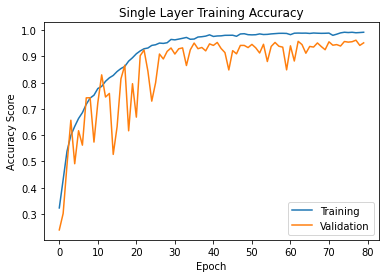

In [60]:
# Create a plot that visualises the training and validation accuracy over time
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Single Layer Training Accuracy')
plt.ylabel('Accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

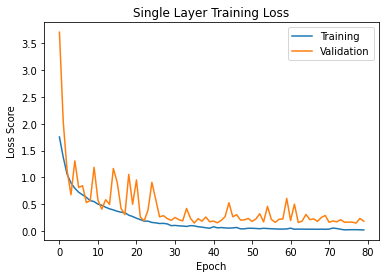

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Single Layer Training Loss')
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [2]:
from tensorflow.keras.models import load_model

In [43]:
model.save("alzheimer_cnn_singleLayer94.92.h5")

In [ ]:
model = load_model('/kaggle/working/alzheimer_cnn_singleLayer94.92.h5')

In [46]:
pred_labels_single = model.predict(test_data)

In [47]:
def roundoff_preds(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels_single:
    labels = roundoff_preds(labels)

print(classification_report(test_labels, pred_labels_single, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.95      1.00      0.97       513
VeryMildDemented       1.00      1.00      1.00       511
    MildDemented       0.95      0.88      0.91       514
ModerateDemented       0.91      0.92      0.91       510

       micro avg       0.95      0.95      0.95      2048
       macro avg       0.95      0.95      0.95      2048
    weighted avg       0.95      0.95      0.95      2048
     samples avg       0.95      0.95      0.95      2048



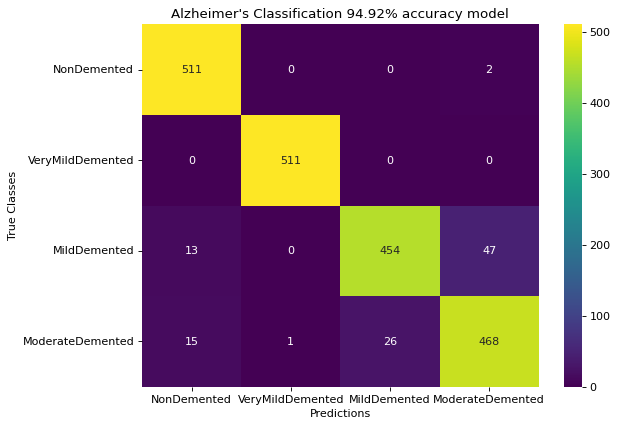

In [64]:
import seaborn as sns
pred_lbl = np.argmax(pred_labels_single, axis=1)
test_lbl = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_lbl, pred_lbl)


plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(conf_arr, cmap='viridis', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)
plt.title('Alzheimer\'s Classification 94.92% accuracy model')
plt.xlabel('Predictions')
plt.ylabel('True Classes')
plt.show(ax)

# Grad-CAM Explanations

In [44]:
def get_img(img_path, size):
    # The img array will hold the selected image we want to produce explanations
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    # The dimensions will transform the image array into an array with the shape (1, 176, 176, 3)
    array = np.expand_dims(array, axis=0)
    return array


def create_gradcam_map(img_array, model, last_conv_layer, pred_index=None):
    # This function creates a model that links the image to the model's activations of the last convolutional layer (before the dense layers),
    # and also connects the activations to the class predictions.
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer).output, model.output]
    )

    # The gradient tape is a tool that calculates the gradient (in this case the first class prediction), linked with the convolutional layer activations.
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_map = preds[:, pred_index]

    # Calculation of the output neuron gradient linked to the last convolutional layer output map
    neuron_grad = tape.gradient(class_map, last_conv_layer_output)

    # Calculating the gradient mean intensity of the output neuron gradient calculation
    pooled_grad = tf.reduce_mean(neuron_grad, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grad[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [69]:
model.summary()

Model: "cnn_model_singleLayers"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 32)        4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 88, 88, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 44, 44, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 

In [121]:
last_conv_layer = "conv2d_4"

In [40]:
img_path = "/kaggle/working/dataset/ModerateDemented/28.jpg"

In [45]:
img = image.load_img(img_path, target_size=(176, 176))

# Prepare image
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is


In [46]:
preds = model.predict(img_array)

In [39]:
def decode_prediction(classes):
    if classes == 0:
        print("Prediction: Mild Demented")
    elif classes == 1: 
        print("Prediction: Moderate Demented")
    elif classes == 2:
        print("Prediction: Non Demented")
    elif classes == 3:
        print("Prediction: Very Mild Demented")
    else: 
        print("There was an error. Please try again.")
    return decode_prediction

In [47]:
classes = np.argmax(preds, axis = 1)

In [48]:
decode_prediction(classes)

Prediction: Non Demented


<function __main__.decode_prediction(classes)>

Prediction: Mild Demented


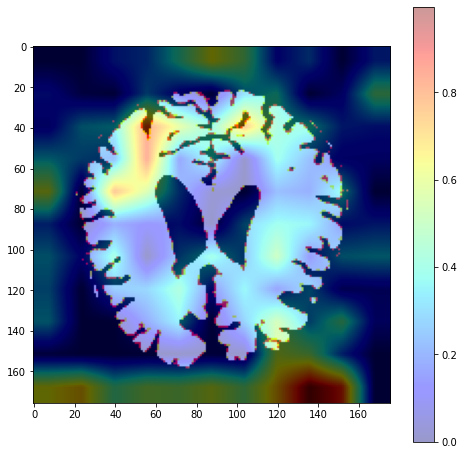

In [83]:
heatmap = create_gradcam_map(img_array, model, last_conv_layer)

decode_prediction(classes)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()

**The inputs image falls under the class moderate demented, but our model's prediction is mild demented. <br>
The differences between a mild demented brain and a moderate one are small, and it is interesting to see whether the model focused in the brain areas affected by alzheimer's or not. <br>
The Grad-CAM visualisation shows that the last convolutional layer's activations were present in a wider area of the image, and not especially in the hippocampus area, <br> 
which explains why the model's prediction is wrong. It is interesting to see that the model has focused on parts of the image that do not include the brain.**

Prediction: Non Demented


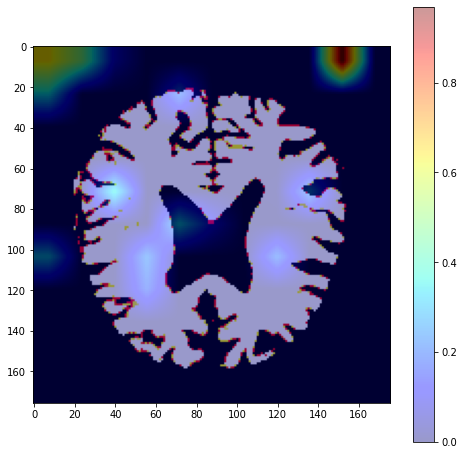

In [97]:
img_path = "/kaggle/working/dataset/VeryMildDemented/26 (48).jpg"
img = image.load_img(img_path, target_size=(176, 176))
# Prepare image by reshaping its dimensions and convert to array
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
classes = np.argmax(preds, axis = 1)
heatmap = create_gradcam_map(img_array, model, last_conv_layer)
decode_prediction(classes)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()

**This image should be classified as as very mild demented. Yet, it is predicted as non demented. The model fails to detect minimal brain cell alterations in the MRI, <br>
and using the Grad-CAM visualisation is understandable why. It fails to focuses on the correct areas of the brain and it appears that there was a confusion on where the important <br>
elements of the picture were.**

Prediction: Mild Demented


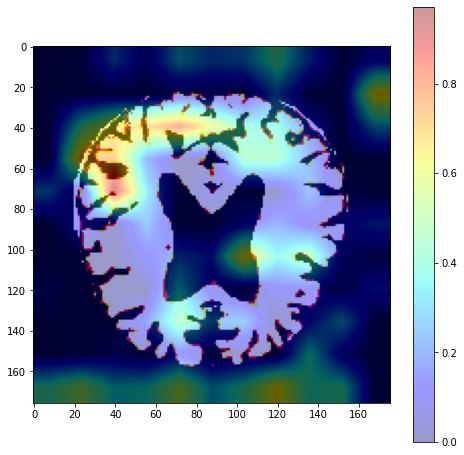

In [118]:
img_path = "/kaggle/working/dataset/MildDemented/26 (20).jpg"
img = image.load_img(img_path, target_size=(176, 176))
# Prepare image by reshaping its dimensions and convert to array
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
classes = np.argmax(preds, axis = 1)
heatmap = create_gradcam_map(img_array, model, last_conv_layer)
decode_prediction(classes)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()

Prediction: Mild Demented


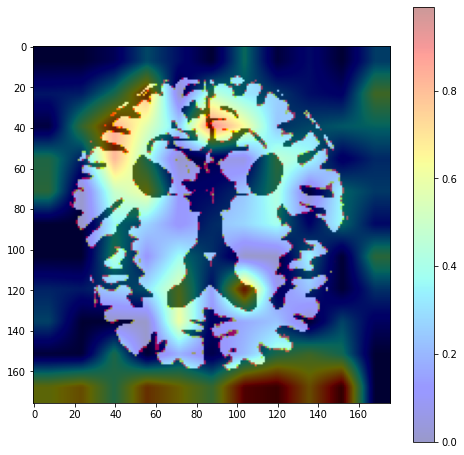

In [138]:
img_path = "/kaggle/working/dataset/ModerateDemented/moderateDem16.jpg"
img = image.load_img(img_path, target_size=(176, 176))
# Prepare image by reshaping its dimensions and convert to array
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
classes = np.argmax(preds, axis = 1)
heatmap = create_gradcam_map(img_array, model, last_conv_layer)
decode_prediction(classes)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()

Prediction: Non Demented


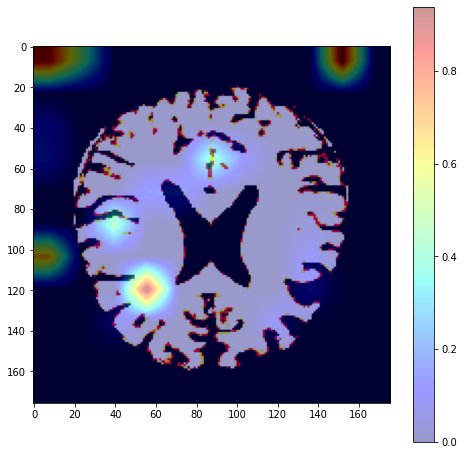

In [140]:
img_path = "/kaggle/working/dataset/NonDemented/26 (63).jpg"
img = image.load_img(img_path, target_size=(176, 176))
# Prepare image by reshaping its dimensions and convert to array
img_array = preprocess_input(get_img(img_path, size=IMAGE_SIZE))
# Remove last layer's softmax
model.layers[-1].activation = None
# Print what the top predicted class is
preds = model.predict(img_array)
classes = np.argmax(preds, axis = 1)
heatmap = create_gradcam_map(img_array, model, last_conv_layer)
decode_prediction(classes)

plt.figure(figsize=(8,8))
plt.imshow(img_array[0])
plt.imshow(tf.image.resize(heatmap[...,np.newaxis], size=(img_array.shape[1], img_array.shape[2]))[:,:,0], alpha=0.4, cmap='jet')
plt.colorbar()
plt.show()